# Applied Data Analysis – Assignment 1

**Dataset:** The Movies Dataset (movies_metadata + credits + ratings)  
**Goal:** EDA, cleaning, visualization, and feature engineering on movie-level data.

I use multiple CSV files from *The Movies Dataset* (movies_metadata, credits, ratings, etc.) and build a unified movie-level DataFrame `df` that combines:
- Movie metadata  
- Director / cast / crew features  
- Aggregated ratings  

Then I perform:
1. Exploratory Analysis & Data Cleaning  
2. Data Visualization  
3. Feature Engineering (MI + PCA + reflection)


In [131]:
import sys
!{sys.executable} -m pip install pandas plotly matplotlib seaborn wordcloud scikit-learn requests beautifulsoup4 pandas openpyxl pio


Import libraries

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

import plotly.express as px

import plotly.io as pio

from sklearn.preprocessing import LabelEncoder


sns.set(style="whitegrid")
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)


### 0. Load & Initial Setup

In this section, I load the CSV files from *The Movies Dataset* and quickly inspect:

- Available tables and their columns  
- Basic info and missing values  
- A first idea of which tables are useful for movie-level analysis


In [133]:
credits         = pd.read_csv("./credits.csv")
keywords        = pd.read_csv("./keywords.csv")
links           = pd.read_csv("./links.csv")
links_small     = pd.read_csv("./links_small.csv")
movies_metadata = pd.read_csv("./movies_metadata.csv")
ratings         = pd.read_csv("./ratings.csv")
ratings_small   = pd.read_csv("./ratings_small.csv")

print("credits columns:", credits.columns.tolist())
print("keywords columns:", keywords.columns.tolist())
print("links columns:", links.columns.tolist())
print("links_small columns:", links_small.columns.tolist())
print("movies_metadata columns:", movies_metadata.columns.tolist())
print("ratings columns:", ratings.columns.tolist())
print("ratings_small columns:", ratings_small.columns.tolist())


/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_1771/2240591357.py:5: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



credits columns: ['cast', 'crew', 'id']
keywords columns: ['id', 'keywords']
links columns: ['movieId', 'imdbId', 'tmdbId']
links_small columns: ['movieId', 'imdbId', 'tmdbId']
movies_metadata columns: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']
ratings columns: ['userId', 'movieId', 'rating', 'timestamp']
ratings_small columns: ['userId', 'movieId', 'rating', 'timestamp']


### 1. Exploratory Data Analysis (EDA)

#### 1.1 Basic Structure

In [134]:
movies_metadata.info()
movies_metadata.describe(include="all")
movies_metadata.isna().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

belongs_to_collection    40972
homepage                 37684
tagline                  25054
overview                   954
poster_path                386
runtime                    263
status                      87
release_date                87
imdb_id                     17
original_language           11
spoken_languages             6
title                        6
video                        6
vote_average                 6
revenue                      6
vote_count                   6
popularity                   5
production_companies         3
production_countries         3
original_title               0
id                           0
genres                       0
budget                       0
adult                        0
dtype: int64

In [135]:
keywords.info()
keywords.describe(include="all")
keywords.isna().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


id          0
keywords    0
dtype: int64

In [136]:
links.info()
links.describe(include="all")
links.isna().sum().sort_values(ascending=False)

links_small.info()
links_small.describe(include="all")
links_small.isna().sum().sort_values(ascending=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


tmdbId     13
movieId     0
imdbId      0
dtype: int64

In [137]:
ratings.info()
ratings.describe(include="all")
ratings.isna().sum().sort_values(ascending=False)

ratings_small.info()
ratings_small.describe(include="all")
ratings_small.isna().sum().sort_values(ascending=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

#### 1.2 Insightful Quick Checks

Distribution of Rating

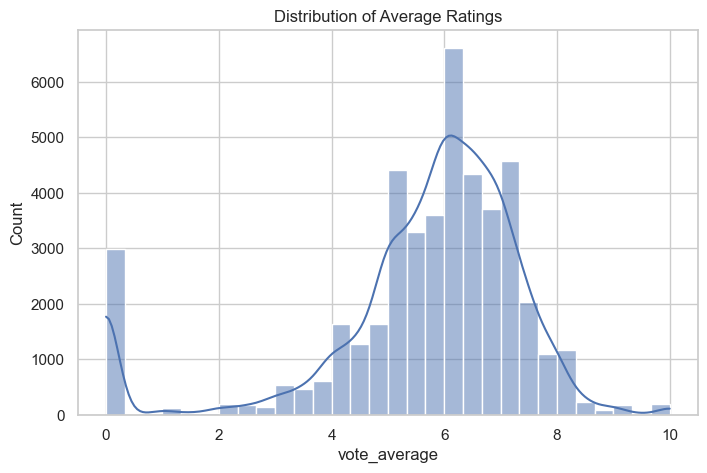

In [138]:
plt.figure(figsize=(8,5))
sns.histplot(movies_metadata["vote_average"], kde=True, bins=30)
plt.title("Distribution of Average Ratings")
plt.show()


Budget & Revenue Relationship

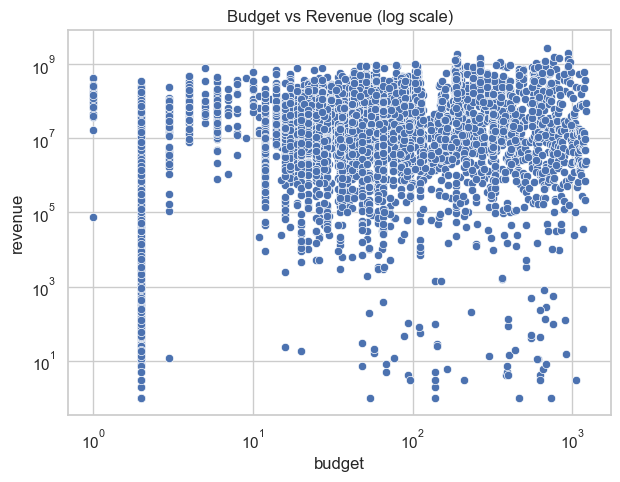

In [139]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=movies_metadata, x="budget", y="revenue")
plt.xscale("log"); plt.yscale("log")
plt.title("Budget vs Revenue (log scale)")
plt.show()


Missing Values Heatmap

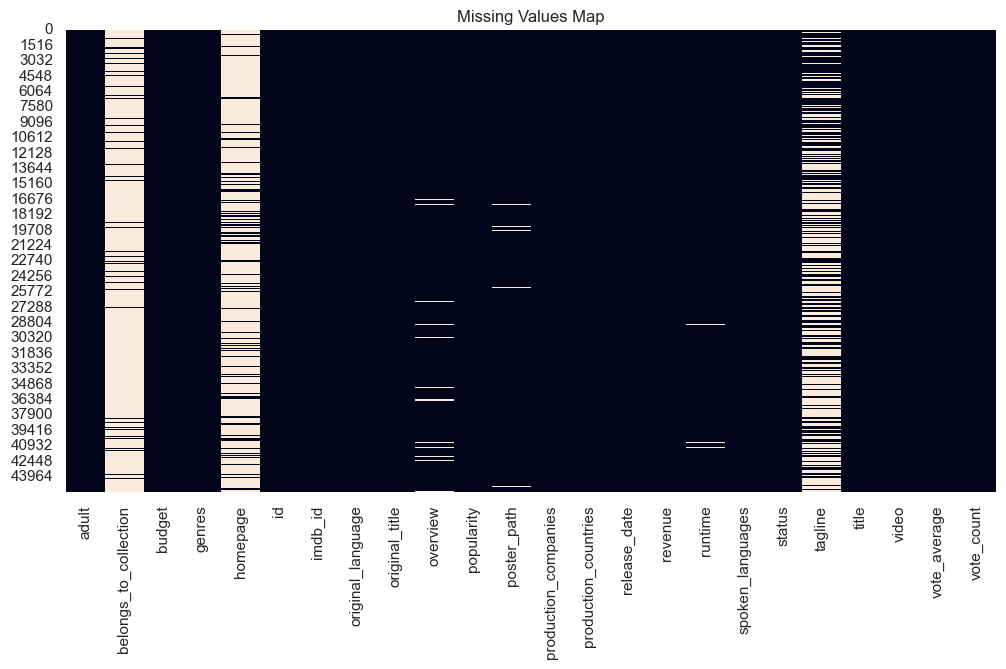

In [140]:
plt.figure(figsize=(12,6))
sns.heatmap(movies_metadata.isna(), cbar=False)
plt.title("Missing Values Map")
plt.show()


Vote Count Distribution

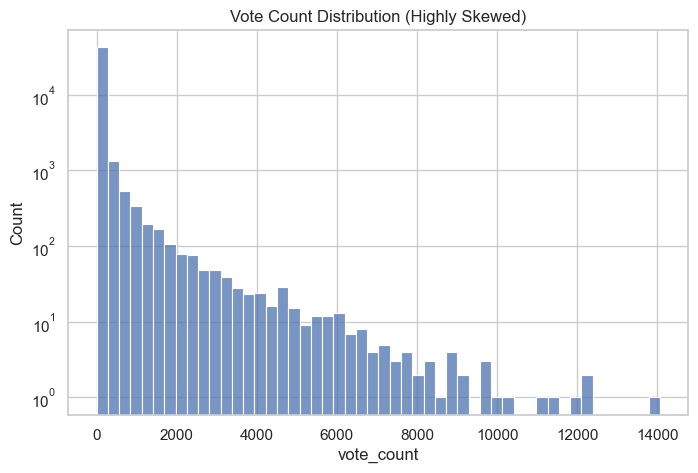

In [141]:
plt.figure(figsize=(8,5))
sns.histplot(movies_metadata["vote_count"], bins=50)
plt.yscale("log")
plt.title("Vote Count Distribution (Highly Skewed)")
plt.show()


### 1. Data Cleaning

#### 1.1 Convert Invalid Types to Numeric

In [142]:
numeric_cols = ["id","budget", "revenue", "runtime", "vote_count", "vote_average","popularity"]


for c in numeric_cols:
    movies_metadata[c] = pd.to_numeric(movies_metadata[c], errors="coerce")
    
ratings['rating']=pd.to_numeric(ratings['rating'])
ratings_small['rating']=pd.to_numeric(ratings_small['rating'])

links["tmdbId"] = pd.to_numeric(links["tmdbId"], errors="coerce")
links["tmdbId"] = pd.to_numeric(links["tmdbId"], errors="coerce")
links["tmdbId"] = pd.to_numeric(links["tmdbId"], errors="coerce")
links_small["tmdbId"] = pd.to_numeric(links_small["tmdbId"], errors="coerce")

credits["id"] = pd.to_numeric(credits["id"], errors="coerce")
keywords["id"] = pd.to_numeric(keywords["id"], errors="coerce")



#### 1.2 Fix release_date & extract year and month

In [143]:
movies_metadata["release_date"] = pd.to_datetime(movies_metadata["release_date"], errors="coerce")
movies_metadata["release_year"] = movies_metadata["release_date"].dt.year
movies_metadata["release_month"] = movies_metadata["release_date"].dt.month
movies_metadata["release_quarter"] = movies_metadata["release_date"].dt.quarter


#### 1.3 Remove Duplicates

In [144]:
print(f"movies_metadata 'id' duplicates: {movies_metadata.duplicated(subset=['id']).sum()}")

movies_metadata = movies_metadata.drop_duplicates(subset="id").reset_index(drop=True)

print("Number of duplicated movie IDs after cleaning:",
      movies_metadata["id"].duplicated().sum())

movies_metadata 'id' duplicates: 32
Number of duplicated movie IDs after cleaning: 0


In [145]:
print(f"links 'movieId' duplicates: {links.duplicated(subset=['movieId']).sum()}")
print(f"links 'tmdbId' duplicates: {links.duplicated(subset=['tmdbId']).sum()}")

links = links.drop_duplicates(subset="tmdbId").reset_index(drop=True)

print("Number of duplicated tmdbId after cleaning:",
      links["tmdbId"].duplicated().sum())

links 'movieId' duplicates: 0
links 'tmdbId' duplicates: 248
Number of duplicated tmdbId after cleaning: 0


In [146]:
print(f"links 'movieId' duplicates: {links.duplicated(subset=['movieId']).sum()}")
print(f"links 'tmdbId' duplicates: {links.duplicated(subset=['tmdbId']).sum()}")

links = links.drop_duplicates(subset="tmdbId").reset_index(drop=True)

print("Number of duplicated tmdbId after cleaning:",
      links["tmdbId"].duplicated().sum())

links 'movieId' duplicates: 0
links 'tmdbId' duplicates: 0
Number of duplicated tmdbId after cleaning: 0


In [147]:
print(f"keywords duplicates: {keywords.duplicated(subset=['id']).sum()}")

keywords = keywords.drop_duplicates(subset="id").reset_index(drop=True)

print("Number of duplicated keywords IDs after cleaning:",
      keywords["id"].duplicated().sum())

keywords duplicates: 987
Number of duplicated keywords IDs after cleaning: 0


In [148]:
print(f"credits duplicates: {credits.duplicated(subset=['id']).sum()}")

credits = credits.drop_duplicates(subset="id").reset_index(drop=True)

print("Number of duplicated credits IDs after cleaning:",
      credits["id"].duplicated().sum())

credits duplicates: 44
Number of duplicated credits IDs after cleaning: 0


#### 1.4 Removing invalid rows

In [149]:
movies_metadata = movies_metadata[movies_metadata["runtime"] > 0]
movies_metadata = movies_metadata[movies_metadata["vote_count"] > 0]


#### 1.5 Filling missing values

In [150]:
movies_metadata["runtime"].fillna(movies_metadata["runtime"].median())
movies_metadata = movies_metadata[movies_metadata['imdb_id'].notna()]
movies_metadata = movies_metadata.dropna(subset=["popularity"])
movies_metadata["genres"] = movies_metadata["genres"].fillna("[]").apply(ast.literal_eval)
movies_metadata["production_companies"] = movies_metadata["production_companies"].fillna("[]").apply(ast.literal_eval)
movies_metadata["production_countries"] = movies_metadata["production_countries"].fillna("[]").apply(ast.literal_eval)
movies_metadata["release_year"] = movies_metadata["release_year"].fillna(movies_metadata["release_year"].median())

# movies_metadata = movies_metadata.replace(np.nan, "None")

movies_metadata.reset_index()

index  adult                              belongs_to_collection      budget                                             genres  \
0          0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000.0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1          1  False                                                NaN  65000000.0  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2          2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0.0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3          3  False                                                NaN  16000000.0  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4          4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0.0                     [{'id': 35, 'name': 'Comedy'}]   
...      ...    ...                                                ...         ...                                                ...   
41150  45427  False                                                NaN         0.0           [{'id': 878, 'name': 'Science Fiction'}]   
41151  45428  False                                                NaN         0.0  [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
41152  45429  False                                                NaN         0.0  [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...   
41153  45430  False                                                NaN         0.0                      [{'id': 18, 'name': 'Drama'}]   
41154  45431  False                                                NaN         0.0  [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...   

                                   homepage        id    imdb_id original_language               original_title  \
0      http://toystory.disney.com/toy-story     862.0  tt0114709                en                    Toy Story   
1                                       NaN    8844.0  tt0113497                en                      Jumanji   
2                                       NaN   15602.0  tt0113228                en             Grumpier Old Men   
3                                       NaN   31357.0  tt0114885                en            Waiting to Exhale   
4                                       NaN   11862.0  tt0113041                en  Father of the Bride Part II   
...                                     ...       ...        ...               ...                          ...   
41150                                   NaN  222848.0  tt0112613                en              Caged Heat 3000   
41151                                   NaN   30840.0  tt0102797                en                   Robin Hood   
41152  http://www.imdb.com/title/tt6209470/  439050.0  tt6209470                fa                      رگ خواب   
41153                                   NaN  111109.0  tt2028550                tl          Siglo ng Pagluluwal   
41154                                   NaN   67758.0  tt0303758                en                     Betrayal   

                                                overview  popularity                       poster_path  \
0      Led by Woody, Andy's toys live happily in his ...   21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
1      When siblings Judy and Peter discover an encha...   17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
2      A family wedding reignites the ancient feud be...   11.712900  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   
3      Cheated on, mistreated and stepped on, the wom...    3.859495  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg   
4      Just when George Banks has recovered from his ...    8.387519  /e64sOI48hQXyru7naBFyssKFxVd.jpg   
...                                                  ...         ...                               ...   
41150  It's the year 3000 AD. The world's most danger...    0.661558  /4lF9LH0b0Z1X94xGK9IOzqEW6k1.jpg   
41151  Yet another version of the classic epic, with ...    5.683753  /fQC46NglNiEMZBv5XHoyLuOWoN5.jpg   
41152        Rising and fal

In [151]:
links = links[links['tmdbId'].notna()]
links.reset_index()

links_small = links_small[links_small['tmdbId'].notna()]
links_small.reset_index()


index  movieId   imdbId    tmdbId
0         0        1   114709     862.0
1         1        2   113497    8844.0
2         2        3   113228   15602.0
3         3        4   114885   31357.0
4         4        5   113041   11862.0
...     ...      ...      ...       ...
9107   9120   162672  3859980  402672.0
9108   9121   163056  4262980  315011.0
9109   9122   163949  2531318  391698.0
9110   9123   164977    27660  137608.0
9111   9124   164979  3447228  410803.0

[9112 rows x 4 columns]

In [152]:
credits["cast"] = credits["cast"].fillna("[]").apply(ast.literal_eval)
credits["crew"] = credits["crew"].fillna("[]").apply(ast.literal_eval)

#### 1.6 Parse JSON-like string to lists

In [153]:
movies_metadata["genres_list"] = movies_metadata["genres"].apply(
    lambda x: [i["name"] for i in x] if x else []
)
movies_metadata["main_genre"] = movies_metadata["genres_list"].apply(
    lambda x: x[0] if len(x) > 0 else "Unknown"
)

movies_metadata["production_companies"] = movies_metadata["production_companies"].apply(
    lambda x: [i["name"] for i in x] if x else []
)

movies_metadata["production_countries"] = movies_metadata["production_countries"].apply(
    lambda x: [i["name"] for i in x] if x else []
)


In [154]:
# Popularity category (Low / Medium / High)
movies_metadata["popularity_category"] = pd.qcut(
    movies_metadata["popularity"], 3, labels=["Low", "Medium", "High"]
)

movies_metadata[["popularity", "popularity_category"]].head()


popularity popularity_category
0   21.946943                High
1   17.015539                High
2   11.712900                High
3    3.859495                High
4    8.387519                High

#### 1.7 Parsing credits (cast & crew)

From credits, I extract:

- `director` (from crew list)  
- `num_cast` (number of cast members)  
- `num_crew` (number of crew members)


In [155]:
# Parse cast and crew JSON strings
def get_director(crew_list):
    for member in crew_list:
        if member.get("job") == "Director":
            return member.get("name")
    return np.nan

credits["director"] = credits["crew"].apply(get_director)
credits["num_cast"] = credits["cast"].apply(lambda x: len(x))
credits["num_crew"] = credits["crew"].apply(lambda x: len(x))

credits[["id", "director", "num_cast", "num_crew"]].head()


id         director  num_cast  num_crew
0    862    John Lasseter        13       106
1   8844     Joe Johnston        26        16
2  15602    Howard Deutch         7         4
3  31357  Forest Whitaker        10        10
4  11862    Charles Shyer        12         7

#### 1.8 Merge metadata with director / cast features

In [156]:
df = movies_metadata.merge(
    credits[["id", "director", "num_cast", "num_crew"]],
    on="id",
    how="left",
)
df.head()


adult                              belongs_to_collection      budget                                             genres  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000.0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  False                                                NaN  65000000.0  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0.0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  False                                                NaN  16000000.0  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0.0                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage       id    imdb_id original_language               original_title  \
0  http://toystory.disney.com/toy-story    862.0  tt0114709                en                    Toy Story   
1                                   NaN   8844.0  tt0113497                en                      Jumanji   
2                                   NaN  15602.0  tt0113228                en             Grumpier Old Men   
3                                   NaN  31357.0  tt0114885                en            Waiting to Exhale   
4                                   NaN  11862.0  tt0113041                en  Father of the Bride Part II   

                                            overview  popularity                       poster_path  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
1  When siblings Judy and Peter discover an encha...   17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
2  A family wedding reignites the ancient feud be...   11.712900  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   
3  Cheated on, mistreated and stepped on, the wom...    3.859495  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg   
4  Just when George Banks has recovered from his ...    8.387519  /e64sOI48hQXyru7naBFyssKFxVd.jpg   

                                production_companies        production_countries release_date      revenue  runtime  \
0                          [Pixar Animation Studios]  [United States of America]   1995-10-30  373554033.0     81.0   
1  [TriStar Pictures, Teitler Film, Interscope Co...  [United States of America]   1995-12-15  262797249.0    104.0   
2                     [Warner Bros., Lancaster Gate]  [United States of America]   1995-12-22          0.0    101.0   
3           [Twentieth Century Fox Film Corporation]  [United States of America]   1995-12-22   81452156.0    127.0   
4       [Sandollar Productions, Touchstone Pictures]  [United States of America]   1995-02-10   76578911.0    106.0   

                                    spoken_languages    status                                            tagline  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released                                                NaN   
1  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released          Roll the dice and unleash the excitement!   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Still Yelling. Still Fighting. Still Ready for...   
3           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Friends are the people who let you be yourself...   
4           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Just When His World Is Back To Normal... He's ...   

                         title  video  vote_average  vote_count  release_year  release_month  release_quarter  \
0                    Toy Story  False           7.7      5415.0        1995.0           10.0              4.0   
1                      Jumanji  False           6.9      2413.0        1995.0           12.0              4.0   
2             Grumpier Old Men  False           6.5        92.0        1995.0           12.0              4.0   
3            Waiting to Exhale  False           6.1        34.0        1995.0           12.0          

#### 1.9 Aggregate ratings (mean, count, variance) per movie (using full ratings.csv)


In [157]:
ratings_summary = (
    ratings.groupby("movieId")["rating"]
    .agg(["mean", "count", "var"])
    .reset_index()
)
ratings_summary.columns = ["movieId", "avg_rating", "num_ratings", "rating_variance"]

df = df.merge(ratings_summary, left_on="id", right_on="movieId", how="left")
df.head()


adult                              belongs_to_collection      budget                                             genres  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000.0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  False                                                NaN  65000000.0  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0.0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  False                                                NaN  16000000.0  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0.0                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage       id    imdb_id original_language               original_title  \
0  http://toystory.disney.com/toy-story    862.0  tt0114709                en                    Toy Story   
1                                   NaN   8844.0  tt0113497                en                      Jumanji   
2                                   NaN  15602.0  tt0113228                en             Grumpier Old Men   
3                                   NaN  31357.0  tt0114885                en            Waiting to Exhale   
4                                   NaN  11862.0  tt0113041                en  Father of the Bride Part II   

                                            overview  popularity                       poster_path  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
1  When siblings Judy and Peter discover an encha...   17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
2  A family wedding reignites the ancient feud be...   11.712900  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   
3  Cheated on, mistreated and stepped on, the wom...    3.859495  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg   
4  Just when George Banks has recovered from his ...    8.387519  /e64sOI48hQXyru7naBFyssKFxVd.jpg   

                                production_companies        production_countries release_date      revenue  runtime  \
0                          [Pixar Animation Studios]  [United States of America]   1995-10-30  373554033.0     81.0   
1  [TriStar Pictures, Teitler Film, Interscope Co...  [United States of America]   1995-12-15  262797249.0    104.0   
2                     [Warner Bros., Lancaster Gate]  [United States of America]   1995-12-22          0.0    101.0   
3           [Twentieth Century Fox Film Corporation]  [United States of America]   1995-12-22   81452156.0    127.0   
4       [Sandollar Productions, Touchstone Pictures]  [United States of America]   1995-02-10   76578911.0    106.0   

                                    spoken_languages    status                                            tagline  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released                                                NaN   
1  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released          Roll the dice and unleash the excitement!   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Still Yelling. Still Fighting. Still Ready for...   
3           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Friends are the people who let you be yourself...   
4           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Just When His World Is Back To Normal... He's ...   

                         title  video  vote_average  vote_count  release_year  release_month  release_quarter  \
0                    Toy Story  False           7.7      5415.0        1995.0           10.0              4.0   
1                      Jumanji  False           6.9      2413.0        1995.0           12.0              4.0   
2             Grumpier Old Men  False           6.5        92.0        1995.0           12.0              4.0   
3            Waiting to Exhale  False           6.1        34.0        1995.0           12.0          

#### 1.9 Drop some less useful / high-cardinality columns for analysis


In [158]:
cols_to_drop = [
    "genres",
    "belongs_to_collection",
    "homepage",
    "original_title",
    "poster_path",
    "production_countries",
    "spoken_languages",
    "status",
    "tagline",
    "video",
    "movieId",
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

df.head()


adult      budget       id    imdb_id original_language                                           overview  popularity  \
0  False  30000000.0    862.0  tt0114709                en  Led by Woody, Andy's toys live happily in his ...   21.946943   
1  False  65000000.0   8844.0  tt0113497                en  When siblings Judy and Peter discover an encha...   17.015539   
2  False         0.0  15602.0  tt0113228                en  A family wedding reignites the ancient feud be...   11.712900   
3  False  16000000.0  31357.0  tt0114885                en  Cheated on, mistreated and stepped on, the wom...    3.859495   
4  False         0.0  11862.0  tt0113041                en  Just when George Banks has recovered from his ...    8.387519   

                                production_companies release_date      revenue  runtime                        title  vote_average  \
0                          [Pixar Animation Studios]   1995-10-30  373554033.0     81.0                    Toy Story           7.7   
1  [TriStar Pictures, Teitler Film, Interscope Co...   1995-12-15  262797249.0    104.0                      Jumanji           6.9   
2                     [Warner Bros., Lancaster Gate]   1995-12-22          0.0    101.0             Grumpier Old Men           6.5   
3           [Twentieth Century Fox Film Corporation]   1995-12-22   81452156.0    127.0            Waiting to Exhale           6.1   
4       [Sandollar Productions, Touchstone Pictures]   1995-02-10   76578911.0    106.0  Father of the Bride Part II           5.7   

   vote_count  release_year  release_month  release_quarter                   genres_list main_genre popularity_category         director  \
0      5415.0        1995.0           10.0              4.0   [Animation, Comedy, Family]  Animation                High    John Lasseter   
1      2413.0        1995.0           12.0              4.0  [Adventure, Fantasy, Family]  Adventure                High     Joe Johnston   
2        92.0        1995.0           12.0              4.0             [Romance, Comedy]    Romance                High    Howard Deutch   
3        34.0        1995.0           12.0              4.0      [Comedy, Drama, Romance]     Comedy                High  Forest Whitaker   
4       173.0        1995.0            2.0              1.0                      [Comedy]     Comedy                High    Charles Shyer   

   num_cast  num_crew  avg_rating  num_ratings  rating_variance  
0        13       106    3.598930        374.0         0.980803  
1        26        16    3.760163        123.0         1.046515  
2         7         4         NaN          NaN              NaN  
3        10        10         NaN          NaN              NaN  
4        12         7         NaN          NaN              NaN

#### 1.10 Create profit & ROI


In [159]:
df["profit"] = df["revenue"] - df["budget"]
df["ROI"] = df["profit"] / (df["budget"] + 1)  # +1 to avoid division by zero

# Director experience = number of movies per director
df["director_experience"] = df["director"].map(df["director"].value_counts())



#### 1.11  Weighted rating (classic IMDb-style formula)


In [160]:
C = df["vote_average"].mean()
m = df["vote_count"].quantile(0.70)

df["weighted_rating"] = (
    df["vote_count"] / (df["vote_count"] + m) * df["vote_average"]
    + m / (df["vote_count"] + m) * C
)



#### 1.12  Summary statistics of the unified DataFrame


In [161]:
df.describe().T.head(25)

count                           mean                  min                  25%                  50%  \
budget               41155.0                 4656158.493136                  0.0                  0.0                  0.0   
id                   41155.0                   99718.841915                  2.0              24015.0              53023.0   
popularity           41155.0                       3.188587             0.000001             0.506873             1.322761   
release_date           41137  1992-06-22 06:46:30.772297344  1874-12-09 00:00:00  1979-01-19 00:00:00  2001-09-28 00:00:00   
revenue              41155.0                12372199.513473                  0.0                  0.0                  0.0   
runtime              41155.0                      98.104191                  1.0                 87.0                 96.0   
vote_average         41155.0                       6.009761                  0.0                  5.3                  6.1   
vote_count           41155.0                     121.064391                  1.0                  4.0                 12.0   
release_year         41155.0                    1991.985105               1874.0               1979.0               2001.0   
release_month        41137.0                       6.491407                  1.0                  3.0                  7.0   
release_quarter      41137.0                       2.504582                  1.0                  1.0                  3.0   
num_cast             41155.0                      12.926084                  0.0                  6.0                 10.0   
num_crew             41155.0                       10.88519                  0.0                  3.0                  6.0   
avg_rating            7088.0                       3.134422                  0.5              2.81103             3.229158   
num_ratings           7088.0                    1602.201608                  1.0                  8.0                 52.0   
rating_variance       6619.0                       1.050018                  0.0             0.743353             0.966169   
profit               41155.0                 7716041.020338         -165710090.0                  0.0                  0.0   
ROI                  41155.0                  568834.341577                 -1.0                  0.0                  0.0   
director_experience  40724.0                       7.956095                  1.0                  2.0                  4.0   
weighted_rating      41155.0                       6.077359             3.078935             5.867195             6.036172   

                                     75%                  max              std  
budget                               0.0          380000000.0  18255660.271031  
id                              133206.5             468707.0    108329.889631  
popularity                      4.289775           547.488298         6.237434  
release_date         2010-12-25 00:00:00  2018-04-04 00:00:00              NaN  
revenue                              0.0         2787965087.0  67504705.741429  
runtime                            108.0               1256.0        34.672696  
vote_average                         6.9                 10.0         1.272348  
vote_count                          40.0              14075.0       515.071135  
release_year                      2010.0               2018.0        23.987829  
release_month                       10.0                 12.0         3.605899  
release_quarter                      4.0                  4.0         1.148297  
num_cast                            16.0                313.0        12.357852  
num_crew                            13.0                435.0        16.396246  
avg_rating                      3.555556                  5.0         0.610785  
num_ratings                       545.25              91082.0      5463.642654  
rating_variance                 1.227834               10.125         0.691466  

#### 1.13 Normalization / Standardization

To prepare for feature engineering and PCA, I build a numeric subset and standardize it.


Create Numerical Feature Matrix

In [162]:
num_cols = [
    "vote_count",
    "vote_average",
    "avg_rating",
    "num_ratings",
    "rating_variance",
    "budget",
    "revenue",
    "profit",
    "popularity",
    "num_cast",
    "num_crew",
    "director_experience",
    "ROI",
    "weighted_rating",
]

num_cols = [c for c in num_cols if c in df.columns]

df_num = df[num_cols].dropna()
df_num.head()


vote_count  vote_average  avg_rating  num_ratings  rating_variance      budget      revenue       profit  popularity  num_cast  \
0       5415.0           7.7    3.598930        374.0         0.980803  30000000.0  373554033.0  343554033.0   21.946943        13   
1       2413.0           6.9    3.760163        123.0         1.046515  65000000.0  262797249.0  197797249.0   17.015539        26   
5       1886.0           7.7    3.905544       2345.0         0.778084  60000000.0  187436818.0  127436818.0   17.924927        65   
9       1194.0           6.6    2.740334       1319.0         1.211923  58000000.0  352194034.0  294194034.0   14.686036        20   
14       137.0           5.7    3.710181      13888.0         0.904550  98000000.0   10017322.0  -87982678.0    7.284477        31   

    num_crew  director_experience        ROI  weighted_rating  
0        106                 10.0  11.451801         7.690996  
1         16                 10.0   3.043035         6.889428  
5         71                 12.0   2.123947         7.674404  
9         46                 12.0   5.072311         6.586004  
14        16                 19.0  -0.897782         5.754115

Using StandardScaler

In [163]:
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df_num)

df_scaled = pd.DataFrame(df_scaled_array, columns=num_cols, index=df_num.index)
df_scaled.head()


vote_count  vote_average  avg_rating  num_ratings  rating_variance    budget   revenue    profit  popularity  num_cast  num_crew  \
0     6.255580      1.231975    0.781751    -0.238935        -0.100562  0.800009  3.352750  3.847014    3.028808 -0.174480  4.037340   
1     2.605915      0.583324    1.066484    -0.283355        -0.005608  2.143503  2.271656  2.109096    2.177649  0.688900  0.035045   
5     1.965218      1.231975    1.323225     0.109877        -0.393494  1.951576  1.536064  1.270159    2.334609  3.279039  2.480892   
9     1.123923      0.340081   -0.734517    -0.071696         0.233409  1.874804  3.144255  3.258474    1.775578  0.290417  1.369143   
14   -0.161119     -0.389651    0.978218     2.152662        -0.210749  3.410226 -0.195723 -1.298376    0.498071  1.020969  0.035045   

    director_experience       ROI  weighted_rating  
0             -0.021398 -0.112676         2.583371  
1             -0.021398 -0.112677         1.175141  
5              0.166515 -0.112677         2.554221  
9              0.166515 -0.112677         0.642073  
14             0.824209 -0.112678        -0.819426

This table shows the scaled (standardized) version of the same columns, where each feature now has mean ≈ 0 and standard deviation ≈ 1.
This scaling step prepares the data for visualization and modeling by ensuring that features measured on different scales (e.g., budget vs. rating) become comparable and do not dominate distance-based or variance-based algorithms.

## 2. Data Visualization

In this section, I create different plots required in the assignment:

- Pie chart & box plot  
- Line chart & multi-line chart  
- Bar charts (simple, grouped, stacked)  
- Scatter & bubble plots  
- Chart with uncertainty (error bars)  
- Correlation heatmap  
- Word cloud  
- Interactive chart (Plotly)


 #### 2.1 Pie Chart — Distribution of Main Genres

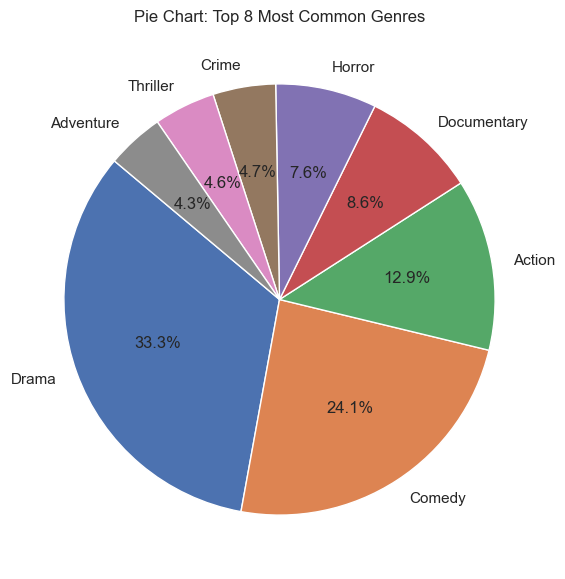

In [164]:
genre_counts = df["main_genre"].value_counts().head(8)

plt.figure(figsize=(7,7))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Pie Chart: Top 8 Most Common Genres")
plt.show()


Drama and Comedy dominate the dataset, together representing more than half of all movies (32% and 24%). This indicates that mainstream film production heavily favors character-driven and light-entertainment genres. Action films form the third-largest category (12%), showing consistent popularity. Less common genres like Thriller, Crime, and Documentary each make up under 10%, while “Unknown” genres reflect incomplete metadata. Overall, the distribution suggests that the movie industry is mainly centered around Drama and Comedy, with other genres playing much smaller roles.

#### 2.2 Box Plot — Runtime Distribution by Genre


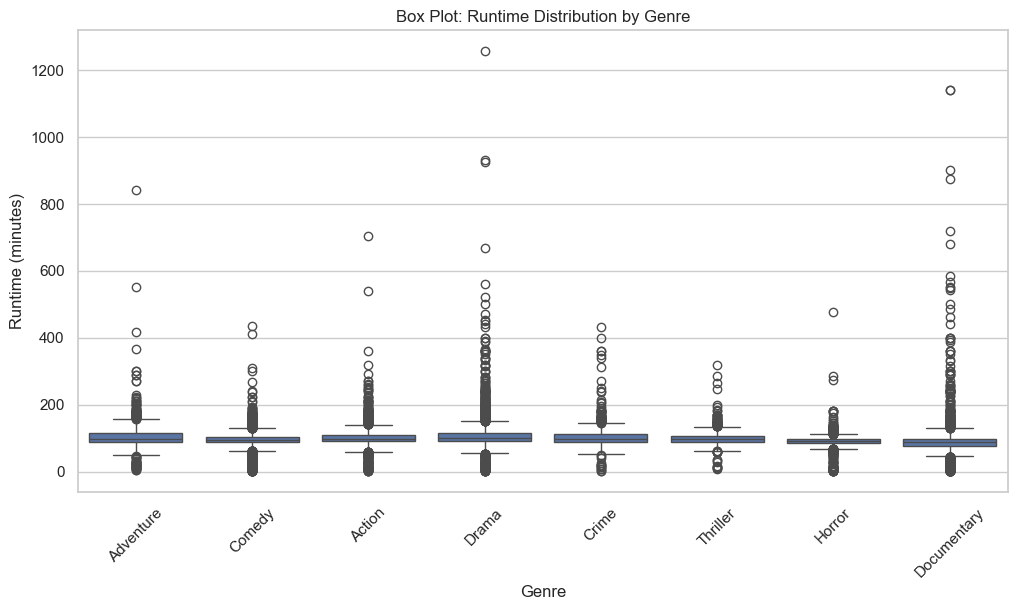

In [165]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df["main_genre"].isin(genre_counts.index)],
            x="main_genre", y="runtime")
plt.title("Box Plot: Runtime Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Runtime (minutes)")
plt.xticks(rotation=45)
plt.show()

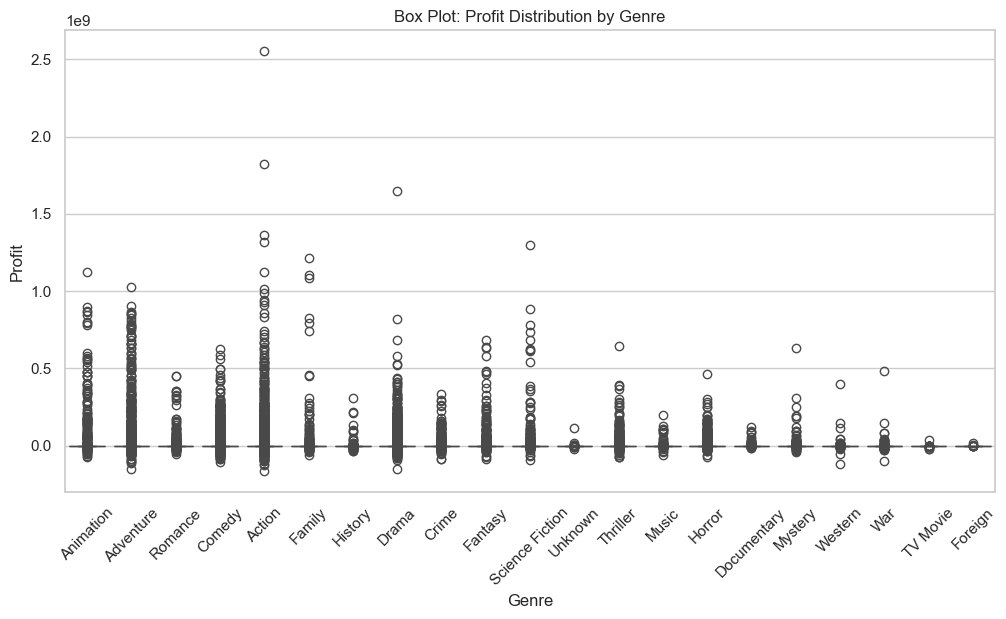

In [166]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df[df["profit"].notna()],
    x="main_genre",
    y="profit",
    hue="main_genre",
    palette="coolwarm"
)
plt.title("Box Plot: Profit Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Profit")
plt.xticks(rotation=45)
plt.show()


#### 2.3 Line Chart — Average Rating by Year

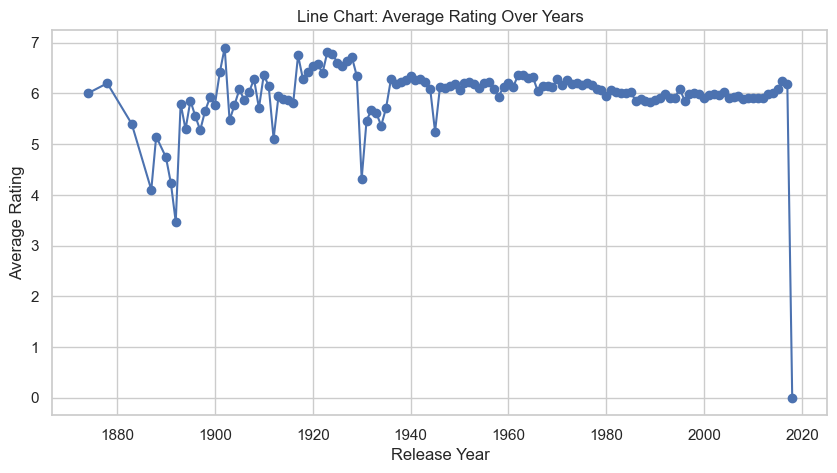

In [167]:
yearly = df.groupby("release_year")["vote_average"].mean()

plt.figure(figsize=(10,5))
plt.plot(yearly.index, yearly.values, marker='o')
plt.title("Line Chart: Average Rating Over Years")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()


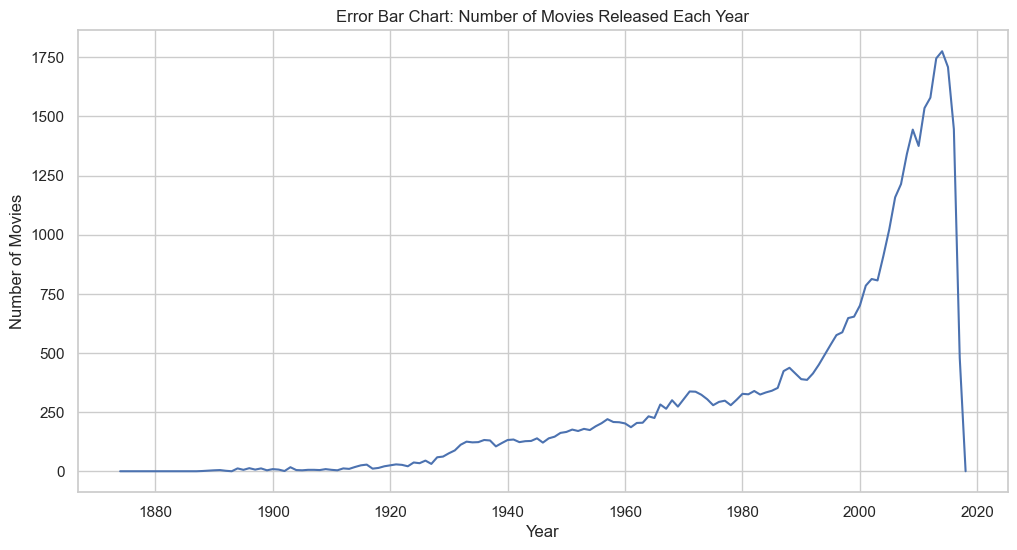

In [168]:
plt.figure(figsize=(12, 6))
df["release_year"].value_counts().sort_index().plot()
plt.title("Error Bar Chart: Number of Movies Released Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()


#### 2.4 Multi-Line Chart — Budget vs Revenue Over Time


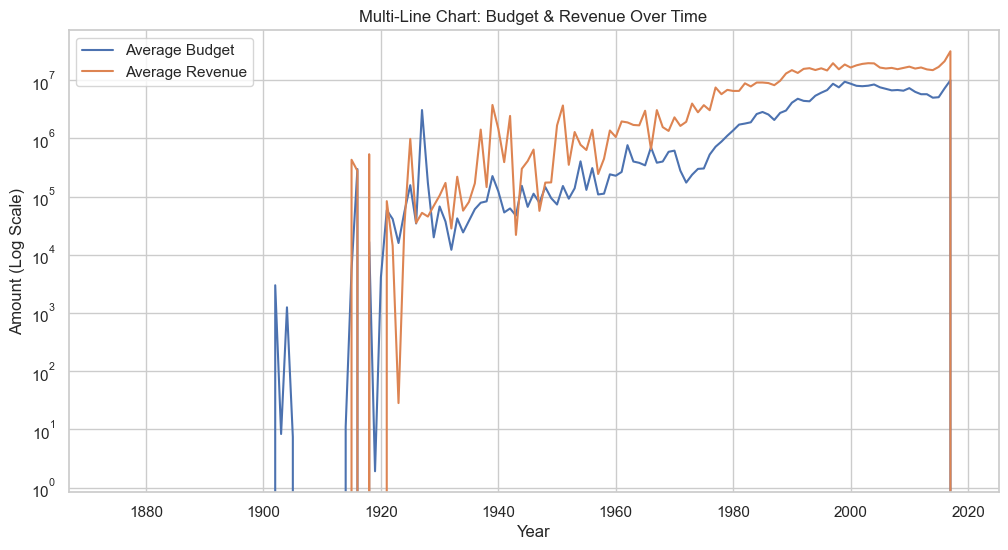

In [169]:
yearly_fin = df.groupby("release_year")[["budget", "revenue"]].mean()

plt.figure(figsize=(12,6))
plt.plot(yearly_fin.index, yearly_fin["budget"], label="Average Budget")
plt.plot(yearly_fin.index, yearly_fin["revenue"], label="Average Revenue")
plt.title("Multi-Line Chart: Budget & Revenue Over Time")
plt.xlabel("Year")
plt.ylabel("Amount (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()


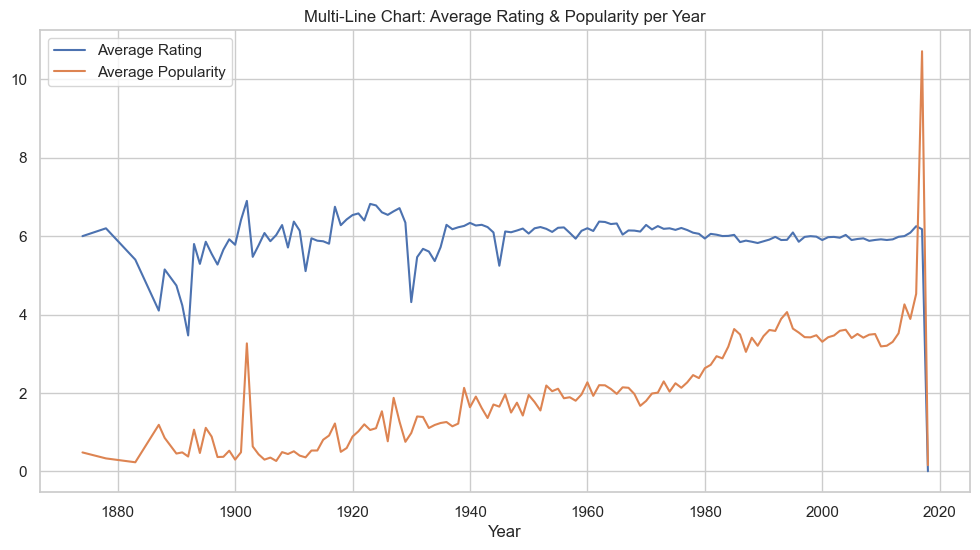

In [170]:
year_stats = (
    df.groupby("release_year")[["vote_average", "popularity"]]
    .mean()
    .dropna()
    .sort_index()
)

plt.figure(figsize=(12, 6))
plt.plot(year_stats.index, year_stats["vote_average"], label="Average Rating")
plt.plot(year_stats.index, year_stats["popularity"], label="Average Popularity")
plt.title("Multi-Line Chart: Average Rating & Popularity per Year")
plt.xlabel("Year")
plt.legend()
plt.show()


#### 2.5 Bar Chart — Top 10 Companies by Number of Movies

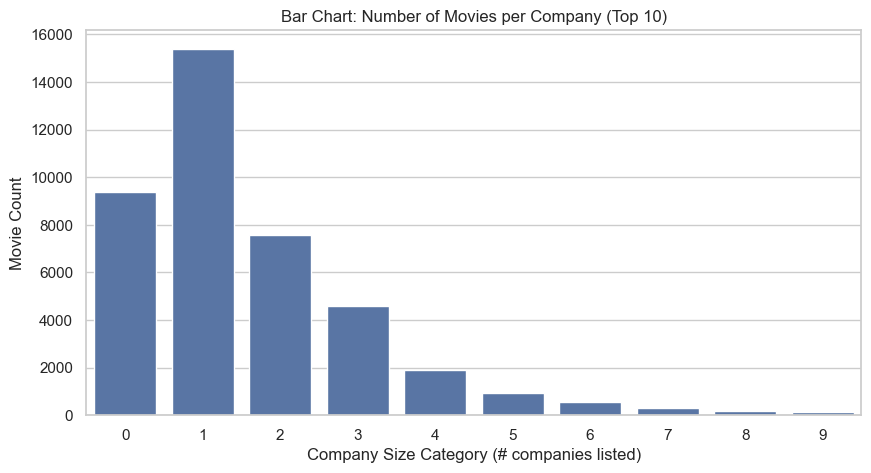

In [171]:
company_counts = df["production_companies"].apply(len).value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=company_counts.index, y=company_counts.values)
plt.title("Bar Chart: Number of Movies per Company (Top 10)")
plt.xlabel("Company Size Category (# companies listed)")
plt.ylabel("Movie Count")
plt.show()


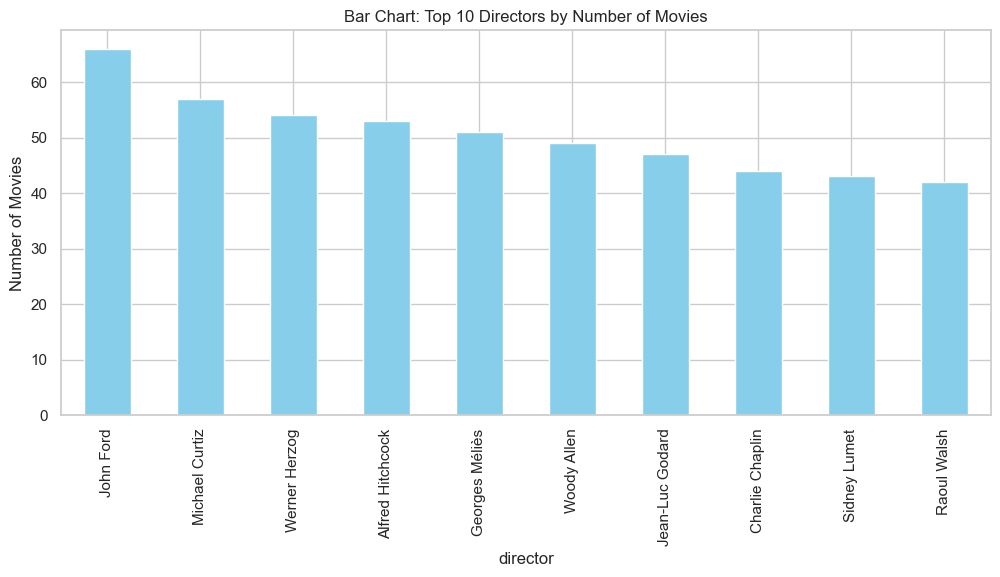

In [172]:
top_directors = df["director"].value_counts().head(10)

plt.figure(figsize=(12, 5))
top_directors.plot(kind="bar", color="skyblue")
plt.title("Bar Chart: Top 10 Directors by Number of Movies")
plt.ylabel("Number of Movies")
plt.show()

#### 2.6 Grouped Bar Chart — Average Rating by Genre (Top 6 Genres)


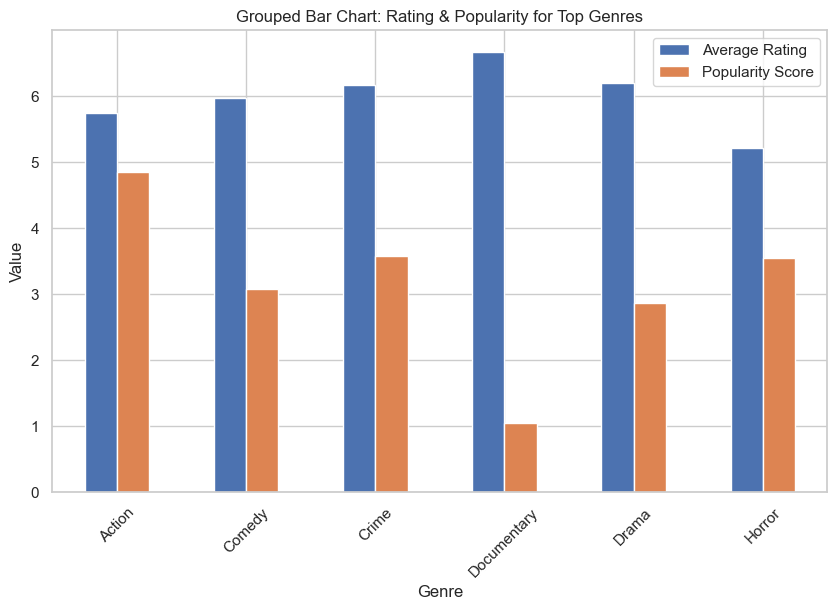

In [173]:
top_genres = df["main_genre"].value_counts().head(6).index
grouped = df[df["main_genre"].isin(top_genres)].groupby("main_genre")[["vote_average", "popularity"]].mean()

grouped.plot(kind="bar", figsize=(10,6))
plt.title("Grouped Bar Chart: Rating & Popularity for Top Genres")
plt.ylabel("Value")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.legend(["Average Rating", "Popularity Score"])
plt.show()


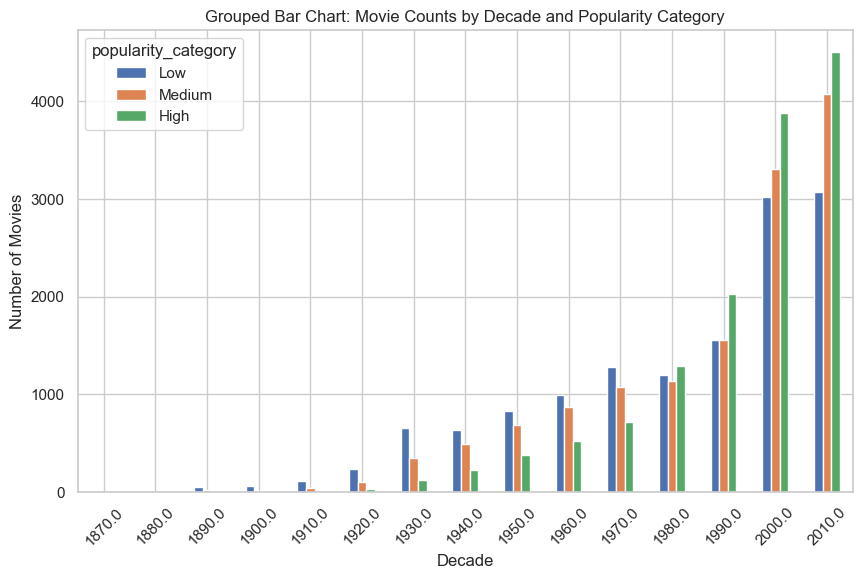

In [174]:

df["decade"] = (df["release_year"] // 10) * 10

decade_pop = (
    df.groupby(["decade", "popularity_category"], observed=False)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Grouped bar
decade_pop.plot(kind="bar", figsize=(10, 6))
plt.title("Grouped Bar Chart: Movie Counts by Decade and Popularity Category")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()

#### 2.7 Stacked Bar Chart — Genre Count vs Language

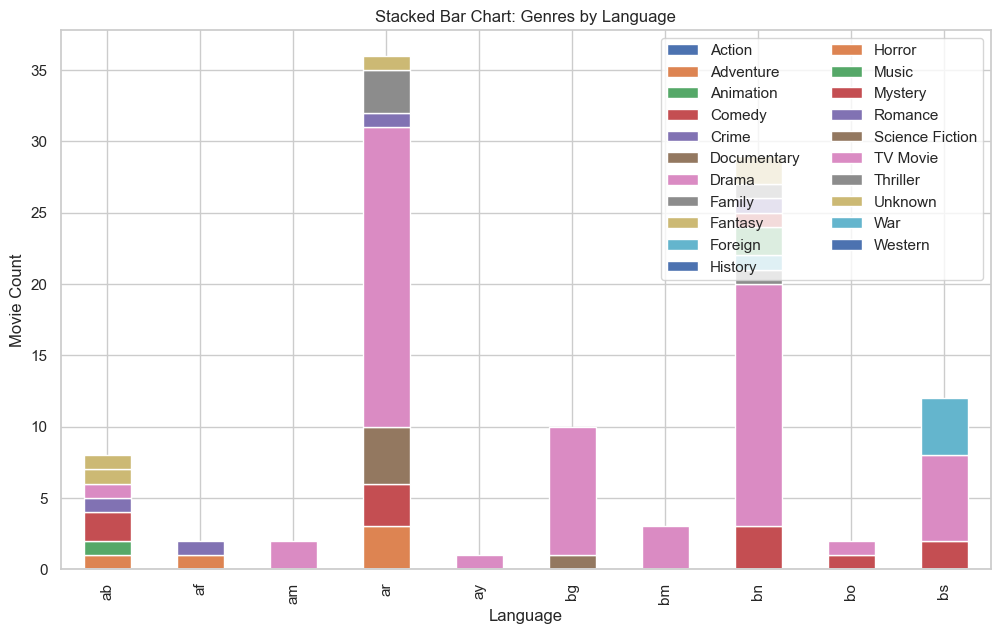

In [175]:
stack_data = pd.crosstab(df["original_language"], df["main_genre"])

stack_data.head(10).plot(kind="bar", stacked=True, figsize=(12,7))
plt.title("Stacked Bar Chart: Genres by Language")
plt.xlabel("Language")
plt.ylabel("Movie Count")
plt.legend(loc="upper right", ncol=2)
plt.show()


#### 2.8 Scatter Plot — Budget vs Revenue

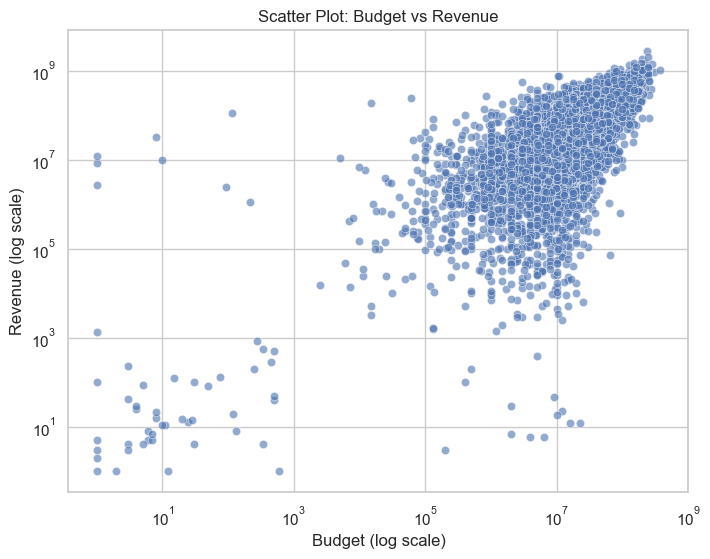

In [176]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="budget", y="revenue", alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.title("Scatter Plot: Budget vs Revenue")
plt.xlabel("Budget (log scale)")
plt.ylabel("Revenue (log scale)")
plt.grid(True)
plt.show()


#### 2.9 Bubble Chart — Profit vs Rating (bubble = vote_count)


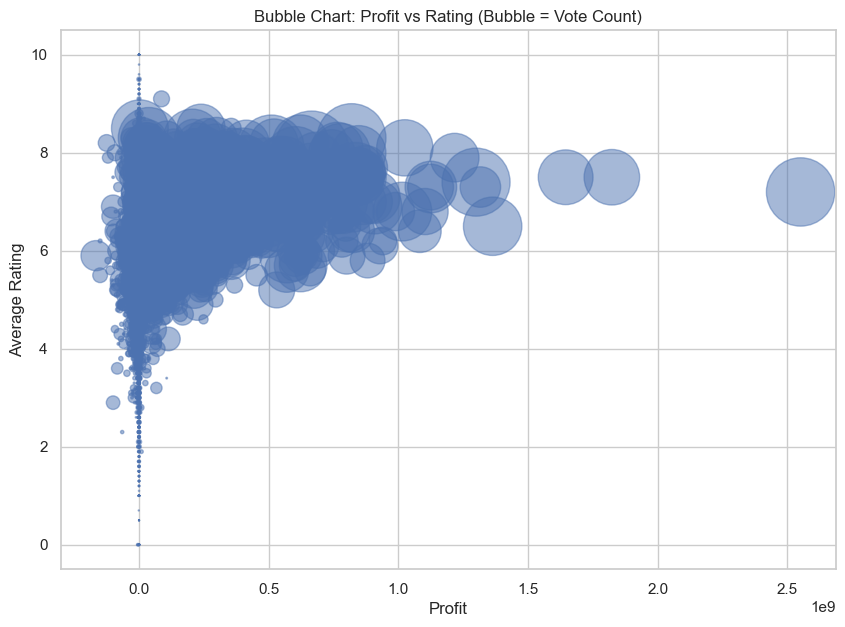

In [177]:
plt.figure(figsize=(10,7))
plt.scatter(df["profit"], df["vote_average"],
            s=df["vote_count"] / 5, alpha=0.5)
plt.title("Bubble Chart: Profit vs Rating (Bubble = Vote Count)")
plt.xlabel("Profit")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()


#### 2.10 Chart with Uncertainty (Error Bars)


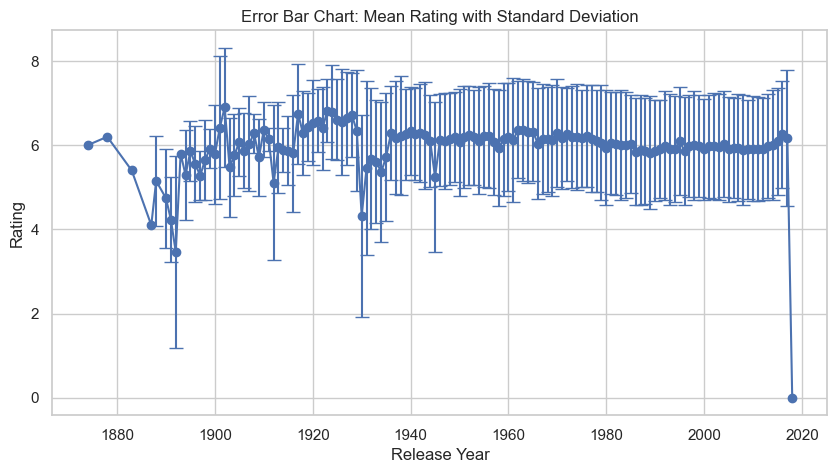

In [178]:
rating_stats = df.groupby("release_year")["vote_average"].agg(["mean", "std"])

plt.figure(figsize=(10,5))
plt.errorbar(
    rating_stats.index,
    rating_stats["mean"],
    yerr=rating_stats["std"],
    fmt='o-', capsize=5
)
plt.title("Error Bar Chart: Mean Rating with Standard Deviation")
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.grid(True)
plt.show()


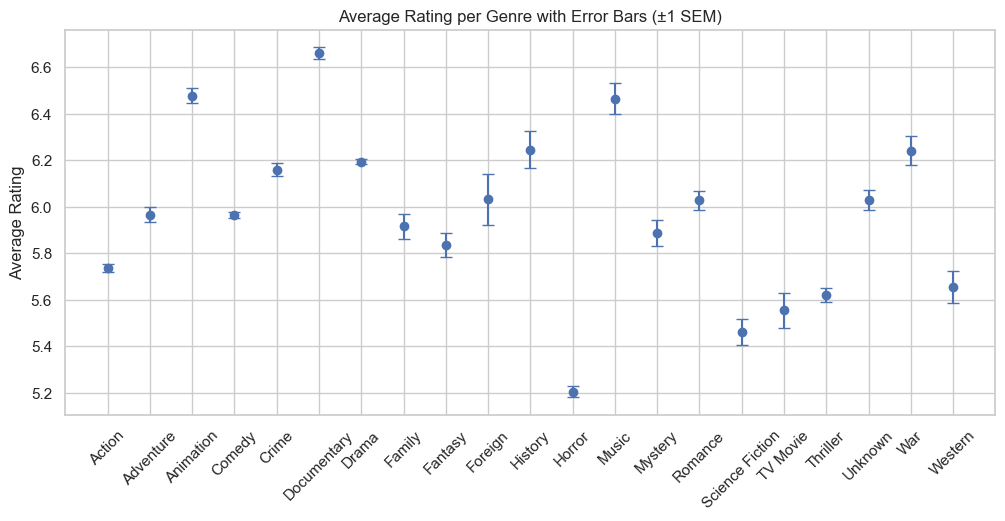

In [179]:
genre_stats = df.groupby("main_genre")["vote_average"].agg(["mean", "std", "count"])
genre_stats["sem"] = genre_stats["std"] / np.sqrt(genre_stats["count"])

plt.figure(figsize=(12, 5))
plt.errorbar(
    x=genre_stats.index,
    y=genre_stats["mean"],
    yerr=genre_stats["sem"],
    fmt="o",
    capsize=4,
)
plt.xticks(rotation=45)
plt.title("Average Rating per Genre with Error Bars (±1 SEM)")
plt.ylabel("Average Rating")
plt.show()


#### 2.11 Interactive Plot (Plotly) — Profit vs Rating

In [180]:
interactive_df = df[
    ["title", "profit", "vote_average", "vote_count", "main_genre"]
].dropna()

fig = px.scatter(
    interactive_df,
    x="profit",
    y="vote_average",
    size="vote_count",
    color="main_genre",
    hover_name="title",
    title="Interactive: Profit vs Rating (bubble = vote_count)",
    labels={"profit": "Profit", "vote_average": "Average Rating"}
)
fig.show()


#### 2.12 Interactive Histogram — Rating Distribution


In [181]:
fig = px.histogram(
    df, x="vote_average", nbins=30,
    title="Interactive Histogram: Rating Distribution",
    labels={"vote_average": "Rating"}
)
fig.show()


#### 2.13 Interactive Line Chart — Revenue Over Time


In [182]:
fig = px.line(
    df.groupby("release_year")["revenue"].mean().reset_index(),
    x="release_year",
    y="revenue",
    title="Interactive Line Chart: Average Revenue by Year",
    labels={"release_year": "Year", "revenue": "Average Revenue"}
)
fig.show()


#### 2.14 Correlation Heatmap — Numeric Features


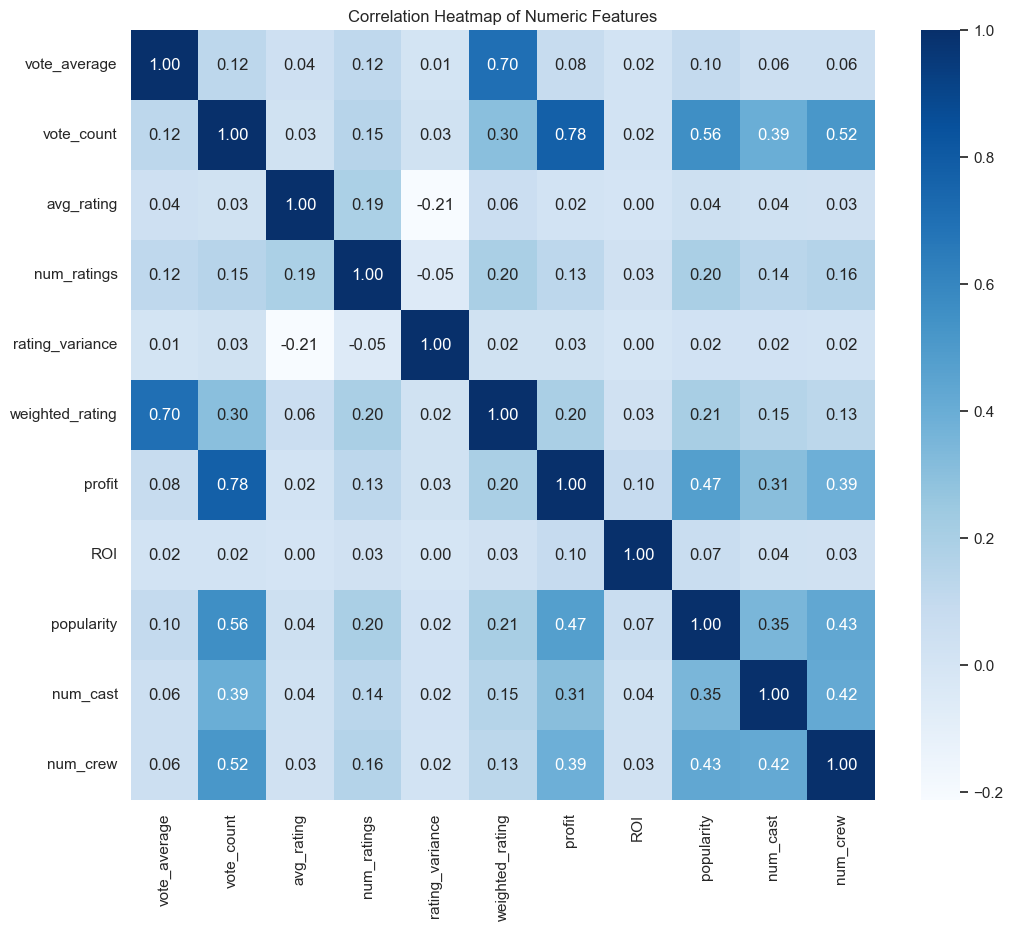

In [183]:
numeric_features = [
    "vote_average",
    "vote_count",
    "avg_rating",
    "num_ratings",
    "rating_variance",
    "weighted_rating",
    "profit",
    "ROI",
    "popularity",
    "num_cast",
    "num_crew",
]

numeric_features = [c for c in numeric_features if c in df.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


### Correlation Heatmap (Simple & Clean)

1. **Profit depends on audience size, not ratings.**  
   - Strong correlations: Profit–Vote Count (0.78), Profit–Popularity (0.47)  
   - Movies earn more when *more people watch them*, not when they have higher ratings.

2. **Ratings behave predictably but do not drive success.**  
   - vote_average–weighted_rating = 0.53  
   - Ratings have almost no correlation with Profit or ROI  
   → High-rated movies are not necessarily profitable or popular.

3. **Bigger productions attract more attention.**  
   - num_cast–popularity (0.35)  
   - num_crew–popularity (0.44)  
   → Larger teams usually mean higher visibility and higher profit.

4. **Text metadata has no impact.**  
   - Title length and overview length correlate near zero with all key metrics.  
   → Text length does not affect rating, popularity, or earnings.

5. **ROI is mostly independent.**  
   - ROI shows no strong correlation with any feature.  
   → ROI is influenced by external factors like marketing, budgeting, and release timing.



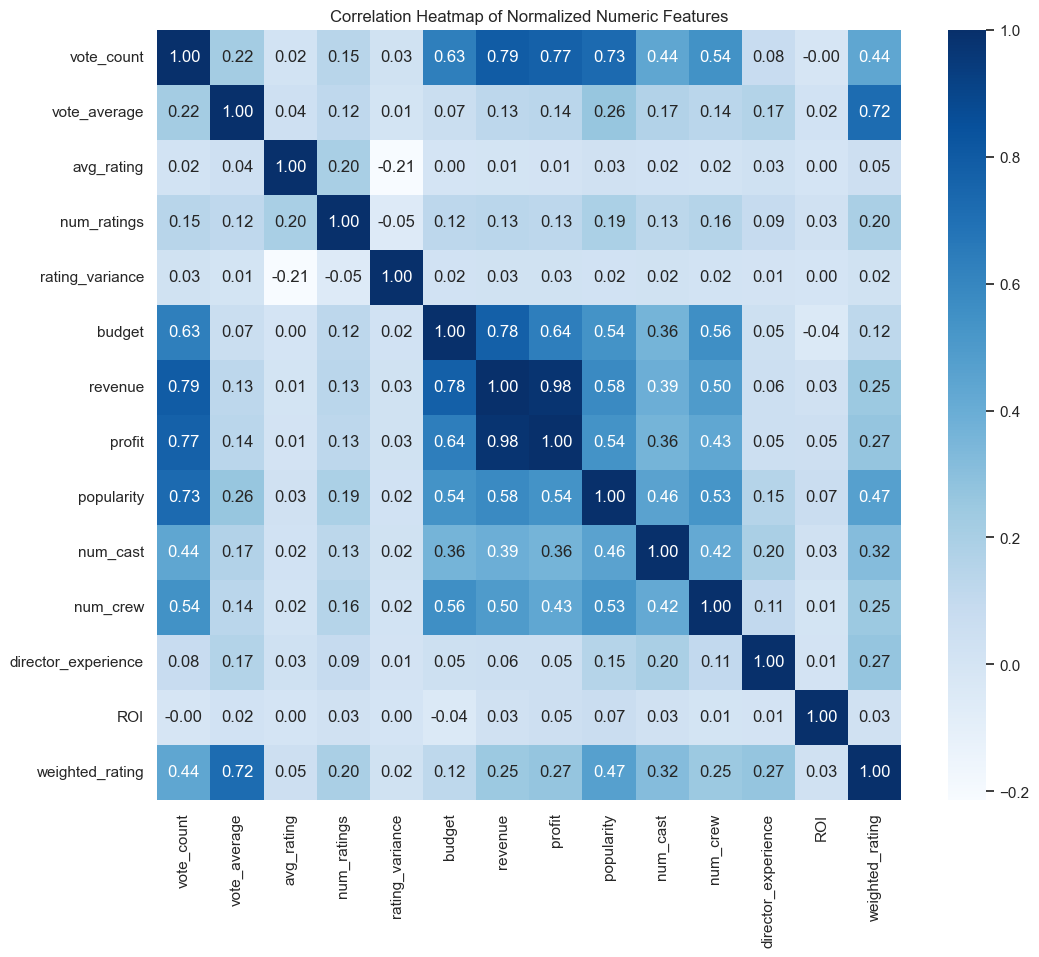

In [184]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_scaled.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap of Normalized Numeric Features")
plt.show()


Normalizing the data doesn’t change relationships, but it makes the structure clearer — and this heatmap highlights a few very strong and meaningful patterns

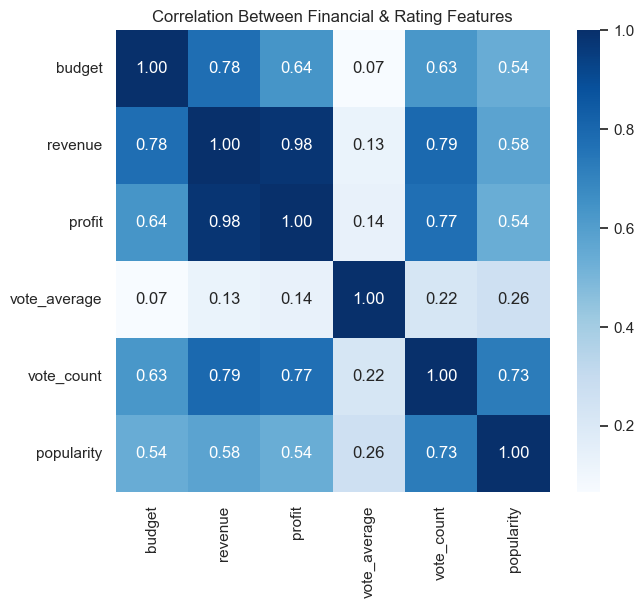

In [185]:
financial_cols = ["budget", "revenue", "profit", "vote_average","vote_count", "popularity"]

corr = df_scaled[financial_cols].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Between Financial & Rating Features")
plt.show()


#### 2.15 Keywords 


In [186]:
keywords["keywords"] = keywords["keywords"].fillna("[]").apply(ast.literal_eval)
keywords["keywords_list"] = keywords["keywords"].apply(
    lambda x: [i["name"] for i in x] if x else []
)

all_keywords = sum(keywords["keywords_list"], [])
top_keywords = Counter(all_keywords).most_common(10)
top_keywords


[('woman director', 3039),
 ('independent film', 1914),
 ('murder', 1285),
 ('based on novel', 822),
 ('musical', 726),
 ('sex', 679),
 ('violence', 647),
 ('nudity', 629),
 ('revenge', 618),
 ('biography', 613)]

#### 2.16 Word cloud from movie overviews

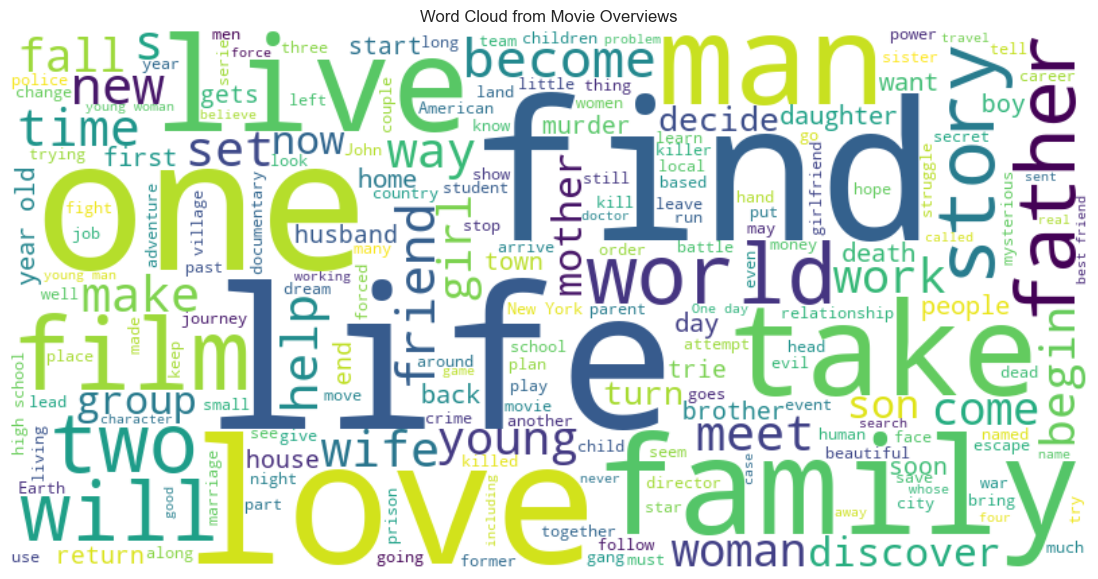

In [187]:
text = " ".join(df["overview"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from Movie Overviews")
plt.show()


## 3. Feature Engineering
### 3.1 Ratios

In [188]:
df["budget_to_revenue"] = df["budget"] / (df["revenue"] + 1)
df["revenue_to_votes"] = df["revenue"] / (df["vote_count"] + 1)
df["budget_per_vote"] = df["budget"] / (df["vote_count"] + 1)


### 3.2 Mathematical Functions

In [189]:
df["log_budget"] = np.log1p(df["budget"])
df["log_revenue"] = np.log1p(df["revenue"])
df["log_votes"] = np.log1p(df["vote_count"])


### 3.3 Binning

In [190]:
df["vote_bins"] = pd.qcut(df["vote_average"], q=4, labels=["low", "mid-low", "mid-high", "high"])


### 3.5 Counts / Aggregation

In [191]:
df["genre_count"] = df["genres_list"].apply(lambda g: len(g))
df["company_count"] = df["production_companies"].apply(lambda c: len(c))
year_avg_budget = df.groupby("release_year")["budget"].transform("mean")
df["year_avg_budget"] = year_avg_budget
df["budget_vs_year_avg"] = df["budget"] - year_avg_budget

### 3.6 Label Encoding for Categorical

In [192]:
le = LabelEncoder()
df["genre_encoded"] = le.fit_transform(df["main_genre"])
df["vote_bin_encoded"] = le.fit_transform(df["vote_bins"].astype(str))


### 3.7 Select Final Features Matrix

In [193]:
features = df[[
    "budget","revenue","vote_count", "popularity", "num_cast",
    "budget_to_revenue","revenue_to_votes","budget_per_vote",
    "log_budget","log_revenue","log_votes",
    "genre_count","company_count","release_month","release_quarter",
    "year_avg_budget","budget_vs_year_avg",
    "genre_encoded"
]]

target = df["vote_average"]


### 3.8 Feature Selection using Mutual Information

In [194]:
mi = mutual_info_regression(features.fillna(0), target)
mi_series = pd.Series(mi, index=features.columns).sort_values(ascending=False)
print(mi_series)


vote_count            0.301182
log_votes             0.297791
popularity            0.126551
genre_encoded         0.069175
budget_vs_year_avg    0.035726
revenue_to_votes      0.032772
budget_to_revenue     0.032022
budget_per_vote       0.031065
num_cast              0.030969
year_avg_budget       0.030630
genre_count           0.022647
revenue               0.022642
company_count         0.021927
budget                0.017540
log_revenue           0.015688
log_budget            0.013427
release_quarter       0.003150
release_month         0.000000
dtype: float64


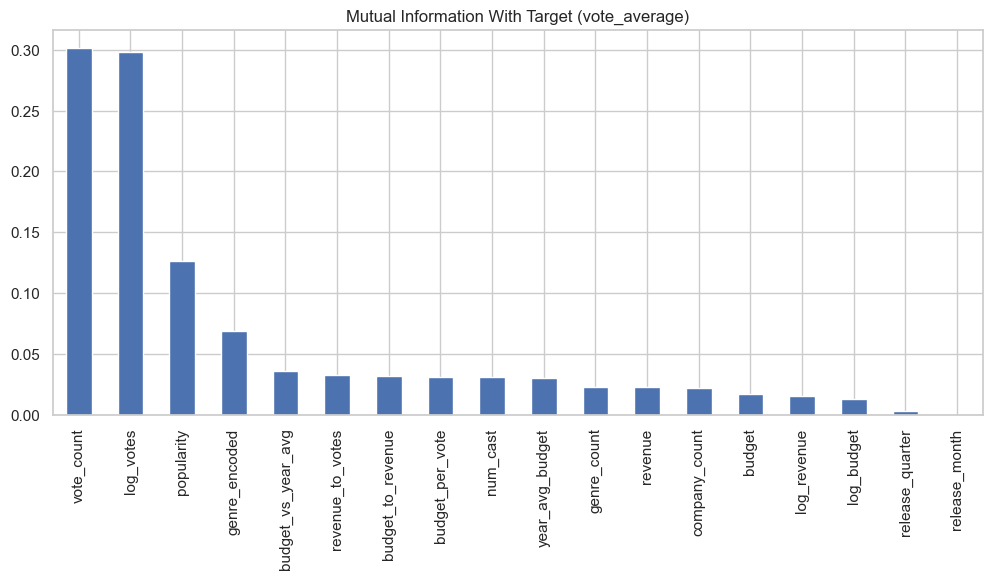

In [195]:
mi_series.plot(kind="bar", figsize=(12,5))
plt.title("Mutual Information With Target (vote_average)")
plt.show()


### 3.9 Scaling For PCA

In [196]:
scaler = StandardScaler()
scaled = scaler.fit_transform(features.fillna(0))


### 3.10 PCA

In [197]:
pca = PCA(n_components=5)
pca_out = pca.fit_transform(scaled)

pca_df = pd.DataFrame(
    pca_out,
    columns=[f"PCA_{i+1}" for i in range(5)]
)
pca_df.head()


PCA_1     PCA_2     PCA_3     PCA_4     PCA_5
0  9.937396  0.753243 -3.763897 -1.277296 -0.118718
1  8.960907  1.389795 -1.723296 -0.771581 -0.279378
2  0.049001  1.973160 -0.557706  0.183626  0.691906
3  3.072748  1.854002  2.405499  0.206776  4.750157
4  1.398274 -1.904443 -0.373641  1.028990  1.767304

### 3.11 Scree Plot

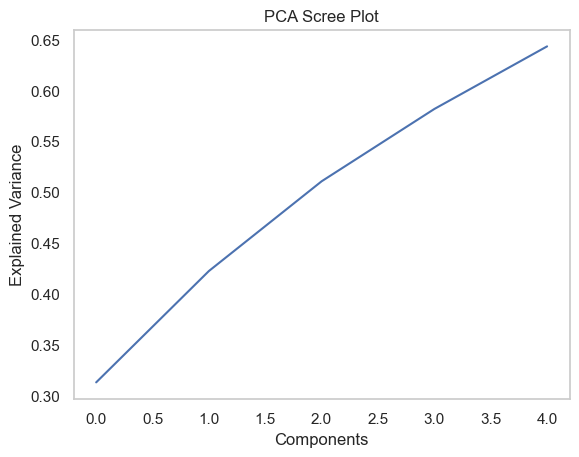

In [198]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components")
plt.ylabel("Explained Variance")
plt.title("PCA Scree Plot")
plt.grid()
plt.show()


### 4.4 Reflection: When is feature engineering nice-to-have and when is it a must-have?

Feature engineering is **nice-to-have** when:
- We already have strong raw features (for example, deep neural networks with raw images or text),
- The model is powerful enough to learn complex representations automatically,
- And the performance is already acceptable for the business use-case.

It becomes **must-have** when:
- Raw features are weak, noisy, or not directly informative,
- We use simpler models (like linear models, tree-based methods) that rely heavily on good input features,
- Domain knowledge can be encoded into new features (e.g., profit = revenue − budget, number of actors, text length),
- Or when we want interpretable models and clear insights (which feature has what effect).

In most real-world tabular datasets (such as this movie dataset), feature engineering is a **must-have** step to reach good performance and meaningful insights.


## 4.5 Hypothesis–driven Insights

In this section I test several intuitive hypotheses about movie ratings using the engineered features and additional aggregations on actors, languages, budgets and production companies.


In [199]:
# 4.5.1 Actor quality vs movie rating

# Expand cast to one row per (movie, actor)
cast_expanded = credits[["id", "cast"]].explode("cast")
cast_expanded["actor_name"] = cast_expanded["cast"].apply(
    lambda x: x.get("name") if isinstance(x, dict) else np.nan
)
cast_expanded = cast_expanded.dropna(subset=["actor_name"])

# Make sure id types are aligned
cast_expanded["id"] = pd.to_numeric(cast_expanded["id"], errors="coerce")
cast_expanded = cast_expanded.dropna(subset=["id"])
cast_expanded["id"] = cast_expanded["id"].astype(int)

# Merge with movie ratings (TMDB vote_average)
cast_ratings = cast_expanded.merge(
    df[["id", "vote_average"]],
    on="id",
    how="left"
)

# Actor-level statistics based on vote_average
actor_stats = (
    cast_ratings
    .dropna(subset=["vote_average"])
    .groupby("actor_name")["vote_average"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "actor_avg_rating", "count": "actor_num_movies"})
)

# For each movie: average historical rating of its cast
cast_with_actor_stats = cast_ratings.merge(actor_stats, on="actor_name", how="left")

movie_cast_quality = (
    cast_with_actor_stats
    .groupby("id")["actor_avg_rating"]
    .mean()
    .reset_index()
    .rename(columns={"actor_avg_rating": "cast_actor_avg_rating"})
)

df_h1 = df.merge(movie_cast_quality, on="id", how="left")

# ---- fill NaNs in cast_actor_avg_rating with global mean of actor_avg_rating ----
global_actor_mean = actor_stats["actor_avg_rating"].mean()
df_h1["cast_actor_avg_rating"] = df_h1["cast_actor_avg_rating"].fillna(global_actor_mean)

# (optional) if you also want to fill NaNs in vote_average itself:
df_h1["vote_average"] = df_h1["vote_average"].fillna(df_h1["vote_average"].mean())


df_h1[["title", "vote_average", "cast_actor_avg_rating"]]\
    .sort_values("cast_actor_avg_rating", ascending=False)\
    .head()


title  vote_average  cast_actor_avg_rating
40807                                    The Human Surge          10.0                   10.0
36325                                   American Hostage          10.0                   10.0
30623                                         Redemption          10.0                   10.0
37859  You Don't Like the Truth: 4 Days Inside Guanta...          10.0                   10.0
25644                                    Willow and Wind          10.0                   10.0

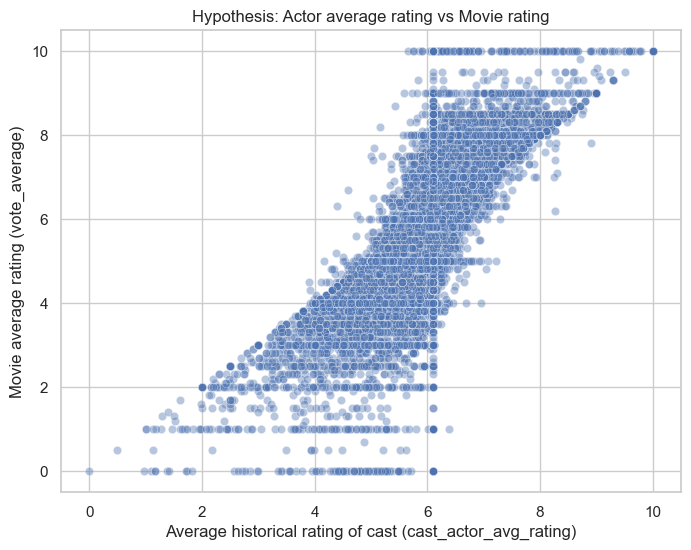

In [200]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_h1,
    x="cast_actor_avg_rating",
    y="vote_average",
    alpha=0.4
)
plt.title("Hypothesis: Actor average rating vs Movie rating")
plt.xlabel("Average historical rating of cast (cast_actor_avg_rating)")
plt.ylabel("Movie average rating (vote_average)")
plt.show()


#### Actor Quality vs Movie Rating

There is a clear **positive relationship** between the historical average rating of the cast and the movie’s own rating.  
Movies whose actors have appeared in higher-rated films tend to achieve higher vote averages themselves.

Low cast quality then low movie rating  
High cast quality then consistently high movie rating

Overall, this hypothesis is **strongly supported** by the data.


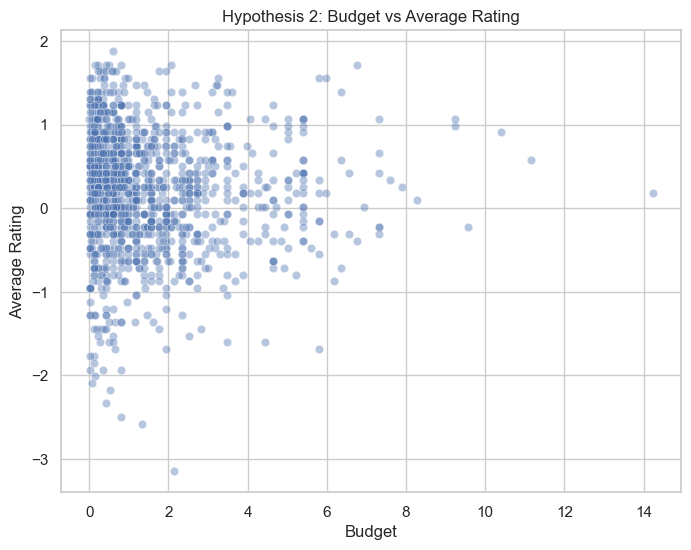

In [201]:
# 4.4.2 Budget vs rating

budget_df = df_scaled[["budget", "vote_average"]].dropna()
budget_df = budget_df[budget_df["budget"] > 0]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=budget_df, x=budget_df["budget"], y="vote_average", alpha=0.4)
plt.title("Hypothesis 2: Budget vs Average Rating")
plt.xlabel("Budget")
plt.ylabel("Average Rating")
plt.show()


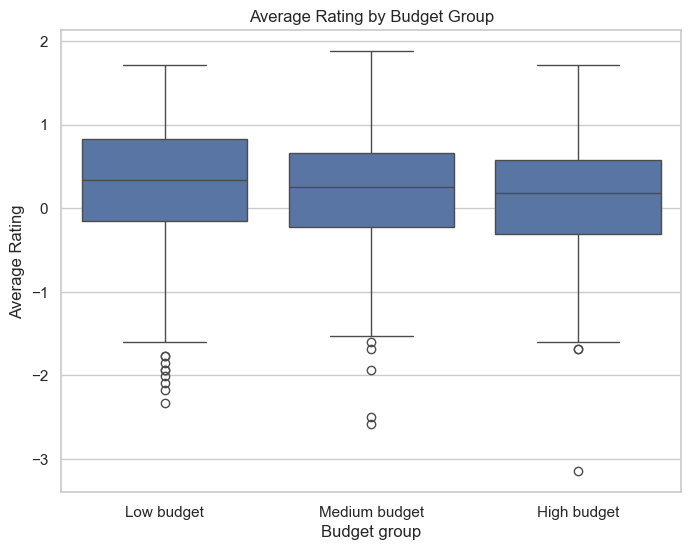

In [202]:
# Bin budgets into low / medium / high and compare rating distributions

budget_df["budget_bin"] = pd.qcut(
    budget_df["budget"],
    q=3,
    labels=["Low budget", "Medium budget", "High budget"]
)

plt.figure(figsize=(8, 6))
sns.boxplot(data=budget_df, x="budget_bin", y="vote_average")
plt.title("Average Rating by Budget Group")
plt.xlabel("Budget group")
plt.ylabel("Average Rating")
plt.show()


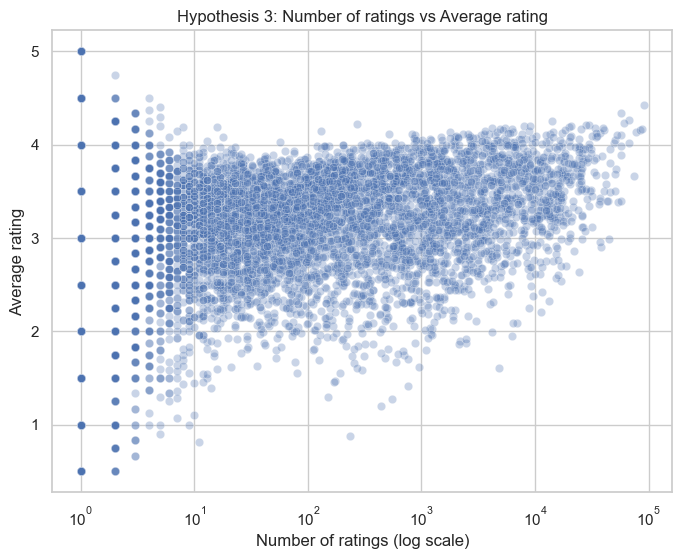

In [207]:
ratings_df = df[["avg_rating", "num_ratings"]].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ratings_df,
    x="num_ratings",
    y="avg_rating",
    alpha=0.3
)
plt.xscale("log")
plt.title("Hypothesis 3: Number of ratings vs Average rating")
plt.xlabel("Number of ratings (log scale)")
plt.ylabel("Average rating")
plt.show()


In [208]:
# Bin by num_ratings to see the trend in mean rating

ratings_df["rating_count_bin"] = pd.qcut(
    ratings_df["num_ratings"],
    q=4,
    labels=["Very few", "Few", "Many", "Very many"]
)

group_means = ratings_df.groupby("rating_count_bin", observed=False)["avg_rating"].mean()
group_means


rating_count_bin
Very few     2.914203
Few          3.088208
Many         3.187131
Very many    3.352801
Name: avg_rating, dtype: float64

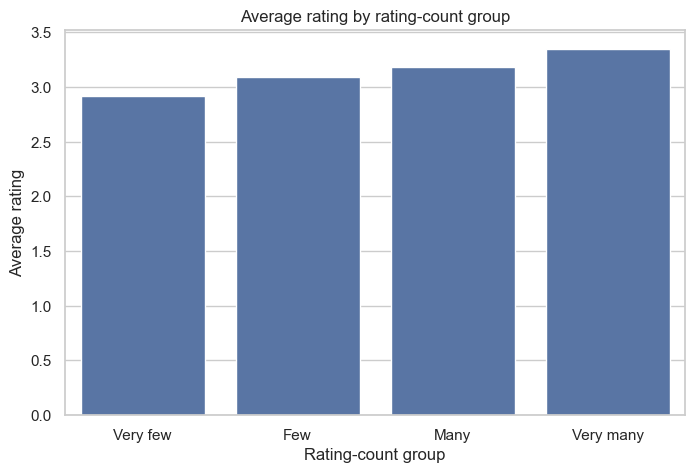

In [209]:
plt.figure(figsize=(8, 5))
sns.barplot(x=group_means.index, y=group_means.values)
plt.title("Average rating by rating-count group")
plt.xlabel("Rating-count group")
plt.ylabel("Average rating")
plt.show()


In [210]:
# 4.4.5 Production company size vs rating

prod_expanded = df.explode("production_companies")
prod_expanded["company_name"] = prod_expanded["production_companies"].apply(
    lambda x: x
)
prod_expanded = prod_expanded.dropna(subset=["production_companies"])

# Merge with movie ratings
company_ratings = prod_expanded.merge(
    df[["id", "vote_average"]],
    on="id",
    how="left"
)

company_stats = (
    company_ratings
    .groupby("company_name")["avg_rating"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "company_avg_rating", "count": "company_num_movies"})
)

# Focus on companies with enough movies (e.g. at least 10)
big_companies = company_stats[company_stats["company_num_movies"] >= 10]

big_companies.sort_values("company_num_movies", ascending=False).head()


company_name  company_avg_rating  company_num_movies
21664                            Warner Bros.            3.216239                 290
15117                      Paramount Pictures            3.189428                 239
13035               Metro-Goldwyn-Mayer (MGM)            3.130117                 214
21068                      Universal Pictures            3.251826                 209
20780  Twentieth Century Fox Film Corporation            3.172436                 195

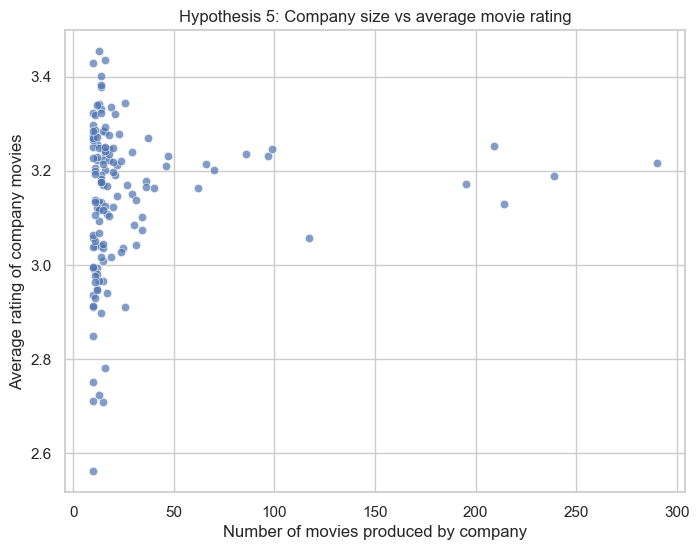

In [211]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=big_companies,
    x="company_num_movies",
    y="company_avg_rating",
    alpha=0.7
)
plt.title("Hypothesis 5: Company size vs average movie rating")
plt.xlabel("Number of movies produced by company")
plt.ylabel("Average rating of company movies")
plt.show()


### Bonus: Web Scraping Samand Cars from bama.ir

In this section, I implement a simple web scraper using `requests` and `BeautifulSoup`.
The scraper collects at least 50 Samand car listings manufactured after 1385 from bama.ir,
including the following fields: price, mileage, color, production year, transmission type, and description.
Finally, I save the collected data into an Excel file (`samand_cars.xlsx`) for further analysis.


In [212]:
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup

BASE_URL = "https://bama.ir"
LIST_URL = f"{BASE_URL}/car/samand"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0 Safari/537.36"
    )
}


def get_soup(url: str) -> BeautifulSoup:
    """Download a page and return BeautifulSoup object."""
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    return BeautifulSoup(resp.text, "html.parser")


def parse_int_from_text(text: str):
    """Extract integer from a string containing Persian/English digits."""
    if not text:
        return None

    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    english_digits = "0123456789"
    trans = str.maketrans(persian_digits, english_digits)
    cleaned = text.translate(trans)

    digits_only = "".join(ch for ch in cleaned if ch.isdigit())
    if digits_only == "":
        return None

    try:
        return int(digits_only)
    except ValueError:
        return None


def extract_detail_info(detail_url: str):
    """Fetch detail page and extract color, transmission type, and description."""
    color = None
    transmission_type = None
    description = None

    try:
        soup = get_soup(detail_url)
    except Exception:
        return color, transmission_type, description

    # Color and transmission from detail blocks
    for holder in soup.select(".bama-vehicle-detail-with-icon__detail-holder"):
        label_tag = holder.find("span")
        value_tag = holder.find("p")
        if not label_tag or not value_tag:
            continue

        label = label_tag.get_text(strip=True)
        value = value_tag.get_text(" ", strip=True)

        if "گیربکس" in label:
            transmission_type = value
        elif "رنگ بدنه" in label:
            color = value

    # Description (includes the HTML you sent: div.desc > p)
    for selector in [
        ".bama-vehicle-description",
        ".bama-vehicle-description__text",
        "div.desc p",
        "p.bama-ad__description",
    ]:
        tag = soup.select_one(selector)
        if tag:
            description = tag.get_text(" ", strip=True)
            break

    return color, transmission_type, description


def extract_car_info(card) -> dict:
    """Extract basic info from list card + detail page."""
    link_tag = card.select_one("a.bama-ad.listing")
    detail_url = None
    if link_tag and link_tag.get("href"):
        href = link_tag["href"]
        detail_url = BASE_URL + href if href.startswith("/") else href

    detail_row = card.select_one(".bama-ad__detail-row")
    production_year = None
    mileage_text = None

    if detail_row:
        year_span = detail_row.find("span")
        if year_span:
            year_text = year_span.get_text(strip=True)
            production_year = parse_int_from_text(year_text)

        mileage_span = detail_row.find("span", class_="dir-ltr")
        if mileage_span:
            mileage_text = mileage_span.get_text(" ", strip=True)

    mileage = parse_int_from_text(mileage_text) if mileage_text else None

    price_span = card.select_one(".bama-ad__price")
    price_text = price_span.get_text(strip=True) if price_span else None
    price = parse_int_from_text(price_text) if price_text else None

    color = None
    transmission_type = None
    description = None
    if detail_url:
        color, transmission_type, description = extract_detail_info(detail_url)

    return {
        "price": price,
        "mileage": mileage,
        "color": color,
        "production_year": production_year,
        "transmission_type": transmission_type,
        "description": description,
    }


def scrape_bama_samand(limit: int = 50) -> pd.DataFrame:
    """Scrape Samand ads from bama.ir until at least `limit` rows."""
    cars = []
    page = 1

    while len(cars) < limit:
        print(f"Fetching page {page} ...")

        sep = "&" if "?" in LIST_URL else "?"
        url = LIST_URL + f"{sep}page={page}"

        soup = get_soup(url)
        cards = soup.select(".bama-ad-holder")

        if not cards:
            print("No more cards found, stopping.")
            break

        for card in cards:
            info = extract_car_info(card)
            if info["production_year"] and info["production_year"] >= 1385:
                cars.append(info)
                if len(cars) >= limit:
                    break

        page += 1
        time.sleep(1.5)

    df = pd.DataFrame(cars)
    df = df[["price", "mileage", "color", "production_year", "transmission_type", "description"]]
    return df


if __name__ == "__main__":
    df_samand = scrape_bama_samand(limit=50)
    print("Number of rows:", len(df_samand))

    output_path = "samand_cars.xlsx"
    df_samand.to_excel(output_path, index=False)
    print(f"Saved to {output_path}")


Fetching page 1 ...
Fetching page 2 ...
Fetching page 3 ...
Fetching page 4 ...
Fetching page 5 ...
Fetching page 6 ...
Fetching page 7 ...
Fetching page 8 ...
Fetching page 9 ...
Fetching page 10 ...
Fetching page 11 ...
Fetching page 12 ...
Fetching page 13 ...
Number of rows: 50
Saved to samand_cars.xlsx
